In [1]:
import torch
import torchvision.datasets as datasets
from tqdm import tqdm
from torch import nn
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import sys
import os
import matplotlib.pyplot as plt
import numpy as np

# adding '../src/model/' to sys.path
sys.path.append(os.path.abspath('../src/model/'))

from model import SuperResolution

In [2]:
# Initialize some constants
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
INPUT_DIM = 1000 # input image is going to be resized to this size
DOWNGRADE_FACTOR = 10 # by how much the image resolution is going to be reduced (downgrade_factor = 10 ==> img.shape /= 10)
BATCH_SIZE = 1

# loading the dataset
data_path = '../data/dataset/test_set' # setting path
# sequence of transformations to be done
transform = transforms.Compose([transforms.Resize((INPUT_DIM, INPUT_DIM)),   # sequence of transformations to be done
                                transforms.Grayscale(num_output_channels=1), # on each image (resize, greyscale,
                                transforms.ToTensor()])                      # convert to tensor)

dataset = datasets.ImageFolder(root=data_path, transform=transform) # read data from folder

# if starting epoch is not 0, load from last trained model
model = SuperResolution().to(DEVICE)
model.load_state_dict(torch.load(f'../models/model_60'))

<All keys matched successfully>

In [3]:
def threshold_map(x, thresh=0.5):
    if x>=thresh:
        return 1
    else: return 0

def binarize_image(img, thresh=0.5):
    img = img.flatten()
    img = np.array(list(map(lambda x: threshold_map(x, 0.5), list(img))))
    img = np.reshape(img, (1000, 1000))
    return img

/home/paulo-vinicius/super-resolution/venv/lib/python3.12/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


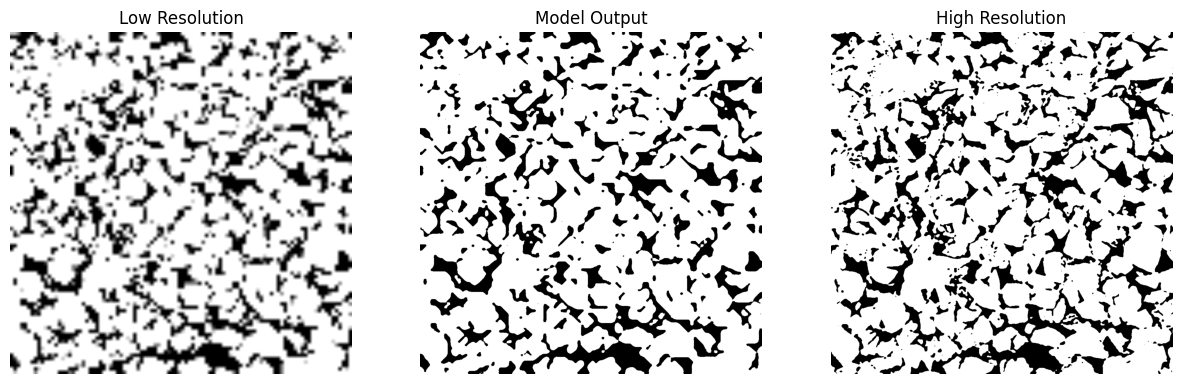

In [4]:
i = np.random.choice(len(dataset))
x = dataset[i][0]

lr_x = F.interpolate(x.unsqueeze(0), size=(INPUT_DIM//DOWNGRADE_FACTOR, INPUT_DIM//DOWNGRADE_FACTOR), mode='bilinear', align_corners=False)
lr_x = F.interpolate(lr_x, size=(INPUT_DIM, INPUT_DIM), mode='bilinear', align_corners=False)

y = model(lr_x[0].to(DEVICE)).cpu()[0].detach().numpy()
y = binarize_image(y, thresh=0.1)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # figsize ajustada para 3 imagens lado a lado
titles = ["Low Resolution", "Model Output", "High Resolution"]
images = [lr_x.cpu()[0][0], y, x.cpu()[0]]

for i in range(3):
    axs[i].imshow(images[i], cmap='gray')
    axs[i].set_title(titles[i])
    axs[i].axis('off')

plt.show()